In [1]:
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import optax
import jax.lax as lax

## Part 1: Forward simulation in 1D

Simplified 1D model: only have x dimension (u)
\begin{aligned}
\frac{\partial u}{\partial t} &= -u \frac{\partial u}{\partial x} - \frac{\partial p}{\partial x}  + \nu \frac{\partial^2 u}{\partial x^2} \\\\
\end{aligned}

Heat evolution:
\begin{align}
\frac{\partial T}{\partial t} + u \frac{\partial T}{\partial x} = \kappa \nabla^2 T
\end{align}

In [2]:
Lx = 1
nx = 100
dx = Lx / (nx - 1)
dt = 0.001
nu = 10
diffusivity = 0.001
dpdx = 0.5

x = jnp.linspace(0, Lx, nx)




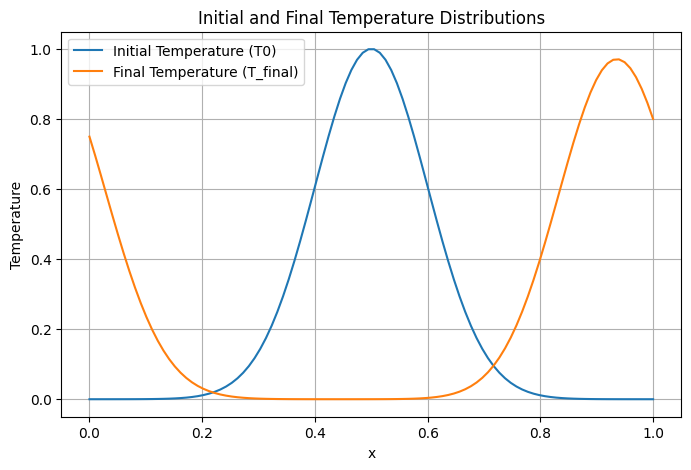

In [3]:
T0 = jnp.exp(-0.5 * ((x - 0.5) / 0.1) ** 2) # initial temperature distribution
u = 1.0 * jnp.ones_like(x) # Initial velocity field

@jax.jit
def heat_evolution(T, u, dx, dt, diffusivity):
    dTdx = (jnp.roll(T, -1) - jnp.roll(T, 1)) / (2 * dx)
    d2Tdx2 = (jnp.roll(T, -1) - 2*T + jnp.roll(T, 1)) / dx**2
    T_rhs = -u * dTdx + diffusivity * d2Tdx2
    T_new = T + dt * T_rhs
    return T_new

@jax.jit
def velocity_evolution(u, dx, dt, nu, dpdx):
    dudx = (jnp.roll(u, -1) - jnp.roll(u, 1)) / (2 * dx)
    d2udx2 = (jnp.roll(u, -1) - 2*u + jnp.roll(u, 1)) / dx**2
    u_rhs = -u * dudx - dpdx + nu * d2udx2
    u_new = u + dt * u_rhs
    return u_new

def run_forward_phase(T0, u0, dx, dt, diffusivity, nu, dpdx, num_steps):
    T, u = T0.copy(), u0.copy()
    for _ in range(num_steps):
        T = heat_evolution(T, u, dx, dt, diffusivity)
        u = velocity_evolution(u, dx, dt, nu, dpdx)
    return T 

T_final = run_forward_phase(T0, u, dx, dt, diffusivity, nu, dpdx, num_steps=500)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, T0, label='Initial Temperature (T0)')
plt.plot(x, T_final, label='Final Temperature (T_final)')
plt.xlabel('x')
plt.ylabel('Temperature')
plt.title('Initial and Final Temperature Distributions')
plt.legend()
plt.grid(True)
plt.show()


## Part 2: Forward simulation in 2D
Simplified representation of stratospheric wind velocity: 2D incompressible Navier-Stokes equations with Coriolis force in Cartesian (ignore vertical structures)
\begin{align}
\frac{\partial u}{\partial t} &= -u \frac{\partial u}{\partial x} - v \frac{\partial u}{\partial y} - \frac{\partial p}{\partial x} + f v  \\
\frac{\partial v}{\partial t} &= -u \frac{\partial v}{\partial x} - v \frac{\partial v}{\partial y} - \frac{\partial p}{\partial y} - f u  
\end{align}

where:
- u, v are wind velocity components in the x, y directions
- p is pressure
- f: Coriolis parameter
- \nu: kinematic viscosity (laminar flow)

since the vertical pressure gradient is dominant in the stratosphere, we've set a constant background pressure gradient

Heat evolution: 
\begin{align}
\frac{\partial T}{\partial t} + u \frac{\partial T}{\partial x} + v \frac{\partial T}{\partial y} = \kappa \nabla^2 T
\end{align}

In [4]:
# Parameters
f = 1e-4    # Coriolis parameter (s^-1)
nu = 10    # Viscosity
diffusivity = 0.01
Lx = 10 # Domain size in x (m)
Ly = 10 # Domain size in y (m)
nx = 100     # Grid points in x
ny = 100    # Grid points in y

# Create grid
x = jnp.linspace(0, Lx, nx)
y = jnp.linspace(0, Ly, ny)
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
X, Y = jnp.meshgrid(x, y, indexing='ij')

In [5]:
# helper functions: computed using finite difference with periodic BCs
def laplacian(field, dx, dy):
    d2f_dx2 = (jnp.roll(field, -1, axis=1) - 2*field + jnp.roll(field, 1, axis=1)) / (dx**2)
    d2f_dy2 = (jnp.roll(field, -1, axis=0) - 2*field + jnp.roll(field, 1, axis=0)) / (dy**2)
    return d2f_dx2, d2f_dy2

def gradient(field, dx, dy):
    dfdx = (jnp.roll(field, -1, axis=1) - jnp.roll(field, 1, axis=1)) / (2*dx)
    dfdy = (jnp.roll(field, -1, axis=0) - jnp.roll(field, 1, axis=0)) / (2*dy)
    return dfdx, dfdy

def divergence(u, v, dx, dy):
    du_dx = (jnp.roll(u, -1, axis=1) - jnp.roll(u, 1, axis=1)) / (2 * dx)
    dv_dy = (jnp.roll(v, -1, axis=0) - jnp.roll(v, 1, axis=0)) / (2 * dy)
    return du_dx + dv_dy

def pressure_gradient(t):
    # constant background atmospheric pressure gradient
    dp_dx = 0.5
    dp_dy = 0.5
    return dp_dx, dp_dy

def solve_poisson(source, dx, dy, n_iter=200, tolerance=1e-8):
    p = jnp.zeros_like(source)
    dx2, dy2 = dx**2, dy**2
    factor = dx2 * dy2 / (2 * (dx2 + dy2))
    
    for i in range(n_iter):
        p_new = factor * (
            (jnp.roll(p, 1, axis=0) + jnp.roll(p, -1, axis=0)) / dy2 +
            (jnp.roll(p, 1, axis=1) + jnp.roll(p, -1, axis=1)) / dx2 -
            source
        )
        
        # Check convergence occasionally
        if i % 50 == 0:
            residual = jnp.max(jnp.abs(p_new - p))
            if residual < tolerance:
                break
        p = p_new
    
    return p

def solve_poisson(source, dx, dy, n_iter=200, tolerance=1e-8):
    dx2, dy2 = dx**2, dy**2
    factor = dx2 * dy2 / (2 * (dx2 + dy2))
    
    def body(i, p):
        p_new = factor * (
            (jnp.roll(p, 1, axis=0) + jnp.roll(p, -1, axis=0)) / dy2 +
            (jnp.roll(p, 1, axis=1) + jnp.roll(p, -1, axis=1)) / dx2 -
            source
        )
        return p_new

    p0 = jnp.zeros_like(source)
    p = lax.fori_loop(0, n_iter, body, p0)
    return p


In [6]:
def streamfunction_to_velocity(psi, dx, dy):
    # to ensure incompressiblity of a 2D flow
    # psi is a scalar field
    dpsi_dx, dpsi_dy = gradient(psi, dx, dy)
    u = -dpsi_dy
    v = dpsi_dx
    return u, v

In [7]:
def coupled_NS_heat(t, state, args):
    psi, T = state # stream function and temperature (stream function ensures incompressibility of velocity field)
    u, v = streamfunction_to_velocity(psi, dx, dy)

    # Navier-Stokes equations for velocity field
    du_dx, du_dy = gradient(u, dx, dy)
    dv_dx, dv_dy = gradient(v, dx, dy)
    d2u_dx2, d2u_dy2 = laplacian(u, dx, dy)
    d2v_dx2, d2v_dy2 = laplacian(v, dx, dy)
    dp_dx, dp_dy = pressure_gradient(t)

    du_dt = - (u * du_dx + v * du_dy + dp_dx) + f * v 
    dv_dt = - (u * dv_dx + v * dv_dy + dp_dy) - f * u 

    # need to solve for dpsi/dt from du_dt and dv_dt:
    # ∂/∂x(∂v/∂t) - ∂/∂y(∂u/∂t) = ∇²(∂ψ/∂t): vorticity = laplacian(streamfunction)
    dv_dt_dx, _ = gradient(dv_dt, dx, dy)
    _, du_dt_dy = gradient(du_dt, dx, dy)
    vorticity = dv_dt_dx - du_dt_dy
    dpsi_dt = solve_poisson(vorticity, dx, dy)

    # head advection-diffusion for temperature
    dT_dx, dT_dy = gradient(T, dx, dy)
    d2T_dx2, d2T_dy2 = laplacian(T, dx, dy)
    dT_dt = - (u * dT_dx + v * dT_dy) + diffusivity * (d2T_dx2 + d2T_dy2)

    return (dpsi_dt, dT_dt)    

In [8]:
@jax.jit
def simulate(psi0, T0, t_end):
    initial_state = (psi0, T0)
    term = diffrax.ODETerm(coupled_NS_heat)
    solver = diffrax.Tsit5()
    #saveat = diffrax.SaveAt(ts=jnp.linspace(0, t_end, 10))
    #stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-5)
    solution = diffrax.diffeqsolve(
        term,
        solver,
        t0=0,
        t1=t_end,
        dt0=0.01,
        y0=initial_state,
        max_steps=10000000,
    )

    psi_final, T_final = solution.ys # final streamfunction + temp
    #return psi_final, T_final, solution.ts
    return psi_final, T_final

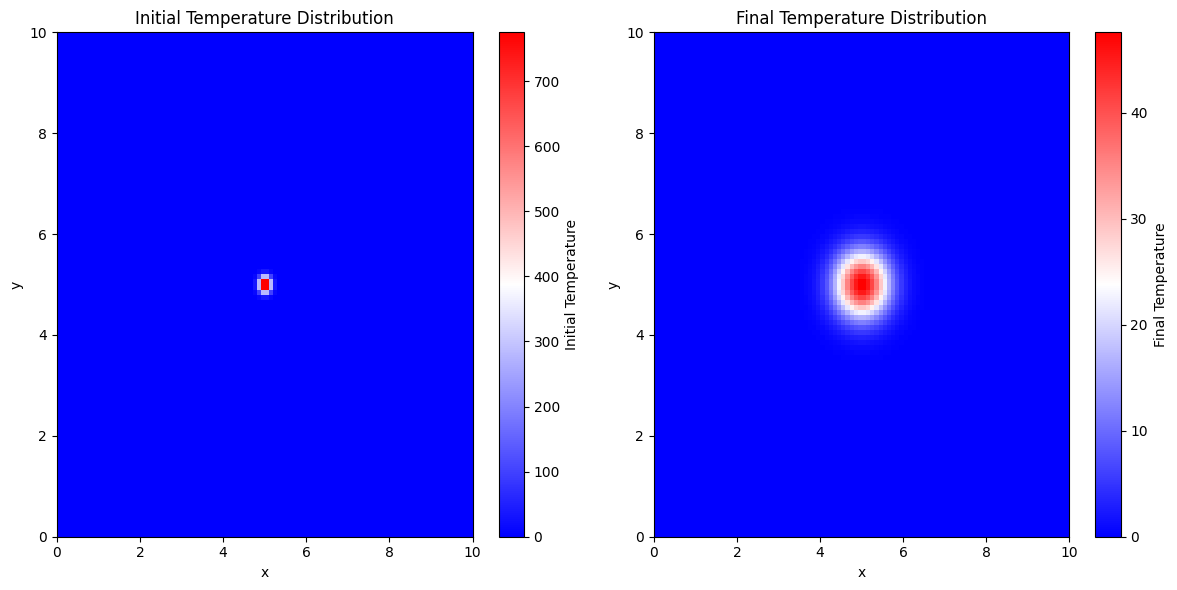

In [9]:
Lx = 10 # Domain size in x (m)
Ly = 10 # Domain size in y (m)
nx = 100     # Grid points in x
ny = 100    # Grid points in y

# Create grid
x = jnp.linspace(0, Lx, nx)
y = jnp.linspace(0, Ly, ny)
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
X, Y = jnp.meshgrid(x, y, indexing='ij')
# Gaussian parameters
x0 = Lx / 2  # center x
y0 = Ly / 2  # center y
sigma_x = 0.1  # std in x
sigma_y = 0.1  # std in y

# 2D Gaussian
gaussian = 1e3 * jnp.exp(-(((X - x0) ** 2) / (2 * sigma_x ** 2) +
                    ((Y - y0) ** 2) / (2 * sigma_y ** 2)))
T0 = jnp.array(gaussian, dtype=jnp.float32)  # initial temperature distribution
psi0 = jnp.zeros_like(T0)  # initial streamfunction 
psi_final, T_final = simulate(psi0, T0, t_end=10)

# Plotting
plt.figure(figsize=(12,6))
# plot initial and final temperature distributions 
plt.subplot(1, 2, 1)
plt.imshow(T0, extent=(0, Lx, 0, Ly), origin='lower', aspect='auto', cmap='bwr')
plt.colorbar(label='Initial Temperature')
plt.title('Initial Temperature Distribution')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.imshow(T_final[0], extent=(0, Lx, 0, Ly), origin='lower', aspect='auto', cmap='bwr')
plt.colorbar(label='Final Temperature')
plt.title('Final Temperature Distribution')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

## Part 3 optimization

In [10]:
# Create target heat distribution
d = 0.5  # desired shift distance
x0_new = x0 + d
y0_new = y0 + d

gaussian_shifted = 1e3 * jnp.exp(-(((X - x0_new) ** 2) / (2 * sigma_x ** 2) +
                             ((Y - y0_new) ** 2) / (2 * sigma_y ** 2)))
T_target = jnp.array(gaussian_shifted, dtype=jnp.float32)  

T_initial = T0 #Lx = 10 =Ly, nx = ny = 100

print(T_target.shape)

(100, 100)


In [11]:
def loss_fn(psi0, T0, T_target):
    psi_initial = psi0.reshape((nx, ny))
    psi_final, T_final = simulate(psi_initial, T0, t_end=10)

    # MSE for heat field matchiing:
    heat_loss = jnp.abs(jnp.mean(T_final[0] - T_target))  # using absolute value for loss
    #heat_loss = jnp.mean((T_final[0] - T_target)**2)
    
    if T_final[0].shape != T_target.shape:
        raise ValueError(f"Shape mismatch: T_final {T_final.shape} vs T_target {T_target.shape}")
    
    if jnp.isnan(heat_loss):
        print("NaN in heat loss")

    return heat_loss 




In [12]:
def optimize_coupled_system():
    key = jax.random.key(42)
    psi0 = 1e-2 * jax.random.normal(key, (nx * ny,))
    optimizer = optax.adam(learning_rate=0.001)
    opt_state = optimizer.init(psi0)
    
    losses = []
    
    for i in range(10):
        loss, grads = jax.value_and_grad(loss_fn)(psi0, T_initial, T_target)

        print(f"Iteration {i}: loss = {loss}")
        if jnp.isnan(loss):
            print("Loss is NaN! Stopping optimization.")
            break
        
        max_grad = jnp.max(jnp.abs(grads))
        print(f"Max gradient magnitude: {max_grad}")
        if jnp.isnan(max_grad):
            print("Gradient contains NaN! Stopping optimization.")
            break
        
        updates, opt_state = optimizer.update(grads, opt_state, psi0)
        psi0 = optax.apply_updates(psi0, updates)

        losses.append(loss)
    
    return psi0, losses

psi_optimized, loss_history = optimize_coupled_system()
# get final results
psi_initial_opt = psi_optimized.reshape((nx, ny))
psi_final_opt, T_final_opt = simulate(psi_initial_opt, T_initial, t_end=10)

# initial and final velocity fields
u_initial, v_initial = streamfunction_to_velocity(psi_initial_opt, dx, dy)
u_final, v_final = streamfunction_to_velocity(psi_final_opt, dx, dy)

# Verify incompressibility
div_initial = divergence(u_initial, v_initial, dx, dy)
div_final = divergence(u_final, v_final, dx, dy)

print(f"\nResults:")
print(f"Initial velocity divergence - Max: {jnp.max(jnp.abs(div_initial)):.2e}, RMS: {jnp.sqrt(jnp.mean(div_initial**2)):.2e}")
print(f"Final velocity divergence - Max: {jnp.max(jnp.abs(div_final)):.2e}, RMS: {jnp.sqrt(jnp.mean(div_final**2)):.2e}")
print(f"Heat transport MSE: {jnp.mean((T_final_opt - T_target)**2):.6f}")
print(f"Initial max velocity: {jnp.max(jnp.sqrt(u_initial**2 + v_initial**2)):.2f} m/s")
print(f"Final max velocity: {jnp.max(jnp.sqrt(u_final**2 + v_final**2)):.2f} m/s")

Iteration 0: loss = 6.335719717753818e-07
Max gradient magnitude: 3.5686089177033864e-06
Iteration 1: loss = 1.1705765246006195e-06
Max gradient magnitude: 3.8451198633993044e-06
Iteration 2: loss = 1.3156262639313354e-06
Max gradient magnitude: 4.005504251836101e-06
Iteration 3: loss = 5.288798092806246e-07
Max gradient magnitude: 3.889314939442556e-06
Iteration 4: loss = 8.621728966318187e-07
Max gradient magnitude: 3.534682036843151e-06
Iteration 5: loss = 1.1489180451462744e-06
Max gradient magnitude: 2.980686076625716e-06
Iteration 6: loss = 8.606838832747599e-07
Max gradient magnitude: 5.76402908336604e-06
Iteration 7: loss = 9.613911515771179e-07
Max gradient magnitude: 3.241667172915186e-06
Iteration 8: loss = 7.206371606116591e-07
Max gradient magnitude: 3.4949262044392526e-06
Iteration 9: loss = 7.220642714855785e-07
Max gradient magnitude: 4.340792656876147e-06

Results:
Initial velocity divergence - Max: 2.38e-07, RMS: 3.30e-08
Final velocity divergence - Max: 0.00e+00, RMS

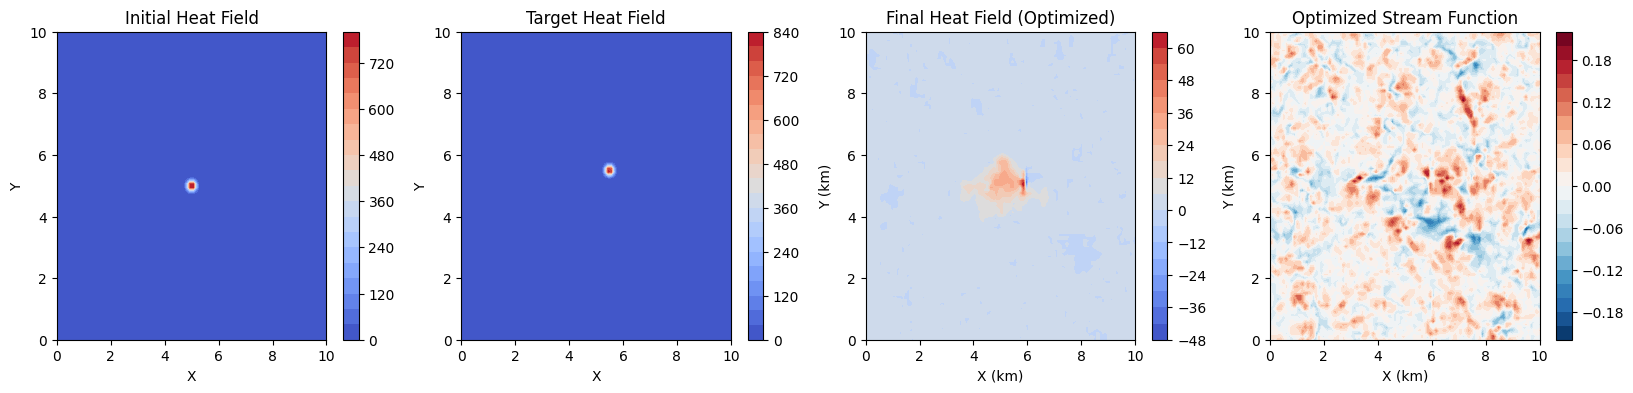

In [19]:
# plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

im1 = axes[0].contourf(X, Y, T_initial, levels=20, cmap='coolwarm')
axes[0].set_title('Initial Heat Field')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].contourf(X, Y, T_target, levels=20, cmap='coolwarm')
axes[1].set_title('Target Heat Field')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].contourf(X, Y, T_final_opt[0], levels=20, cmap='coolwarm')
axes[2].set_title('Final Heat Field (Optimized)')
axes[2].set_xlabel('X (km)')
axes[2].set_ylabel('Y (km)')
plt.colorbar(im3, ax=axes[2])

# Row 2: Stream function and velocity
im4 = axes[3].contourf(X, Y, psi_final_opt[0], levels=20, cmap='RdBu_r')
axes[3].set_title('Optimized Stream Function')
axes[3].set_xlabel('X (km)')
axes[3].set_ylabel('Y (km)')
plt.colorbar(im4, ax=axes[3])






In [20]:
import sys

def print_dependencies():
    print("\n=== Dependencies ===")
    print(f"Python: {sys.version.split()[0]}")
    import jax, diffrax, optax, matplotlib, numpy
    print(f"JAX: {jax.__version__}")
    print(f"Diffrax: {diffrax.__version__}")
    print(f"Optax: {optax.__version__}")
    print(f"Matplotlib: {matplotlib.__version__}")
    print(f"Numpy: {numpy.__version__}")
    print("====================\n")

print_dependencies()



=== Dependencies ===
Python: 3.13.1
JAX: 0.6.2
Diffrax: 0.7.0
Optax: 0.2.5
Matplotlib: 3.10.3
Numpy: 2.3.1

